In [35]:
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from contextlib import contextmanager
from itertools import islice

from oil.cnnTrainer import CnnTrainer
from oil.datasets import CIFAR10, C10augLayers
from oil.networkparts import layer13
from oil.schedules import cosLr
from oil.utils import to_gpu
from oil.extra.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag
from oil.extra.mvm import get_eigs,get_eigs_l, Hvm, Fvm, flatten, to_matmul,add
from oil.extra.mvm import autoHvpBatch, fdHvpBatch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CNN Configuration

In [2]:
train_epochs = 150
net_config =        {'numClasses':10}
opt_config =        {'lr':.1, 'momentum':.9, 'weight_decay':1e-4, 'nesterov':True}
sched_config =      {'cycle_length':train_epochs,'cycle_mult':1}
trainer_config =    {'amntLab':1, 'amntDev':5000,'dataseed':0,
                    'lab_BS':50, 'num_workers':4, 'log':False, 
                    }
trainer_config['description'] = "13Layer network, {} dev".format(trainer_config['amntDev'])
savedir = None#'/home/maf388/tb-experiments/layer13dev/'

def makeTrainer():
    CNN = layer13(**net_config)
    fullCNN = nn.Sequential(C10augLayers(),CNN)
    datasets = CIFAR10(aug=False)
    opt_constr = lambda params: optim.SGD(params, **opt_config)
    lr_lambda = cosLr(**sched_config)
    return CnnTrainer(fullCNN, datasets, opt_constr, lr_lambda, **trainer_config)

In [36]:
trainer = makeTrainer()
trainer.load_checkpoint('/home/maf388/tb-experiments/layer13dev/checkpoints/c.150.ckpt')
_ = trainer.CNN.eval()

Files already downloaded and verified
Files already downloaded and verified
Creating Train, Dev split         with 45000 Train and 5000 Dev
=> loading checkpoint '/home/maf388/tb-experiments/layer13dev/checkpoints/c.150.ckpt'


In [37]:
trainer.getAccuracy(trainer.dev)

0.9442

In [38]:
#trainer = ToyTrainer()

In [39]:
def norm(ray):
    sum_sqrs = 0
    for elem in ray:
        sum_sqrs += torch.norm(elem.data)**2
    return float(np.sqrt(sum_sqrs))

In [40]:
v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
v /= v.norm()
print(norm(trainer.CNN.parameters()))
with add(trainer.CNN, 80*v):
    print(norm(trainer.CNN.parameters()))
print(norm(trainer.CNN.parameters()))

59.627281188964844
99.75032043457031
59.627281188964844


In [65]:
derivStencils=[[-1.,1.], [1/12,-2/3,0.,2/3,-1/12],[-1/60,3/20,-3/4,0.,3/4,-3/20,1/60]]
derivStencilOrders = [2,4,6]

In [66]:
type(derivStencils[0][0])

float

In [67]:
class myslice(object):
    def __init__(self, dataloader, k):
        self.k = k
        self.dloader = dataloader
    def __iter__(self):
        return islice(iter(self.dloader),self.k)

In [68]:
_ = trainer.CNN.eval()

In [83]:
double = True
cpu = True
trials = 1
epsValues = 10**np.linspace(-3,1,10)
it = myslice(trainer.dev,1)
if cpu: trainer.CNN.cpu()
else: trainer.CNN.cuda()
if double: trainer.CNN.double()
else: trainer.CNN.float()

In [84]:
v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
trainData = to_gpu(next(iter(it)),double=double,cpu=cpu)
x,y = trainData

In [85]:
%timeit with torch.autograd.no_grad(): batch_loss = F.cross_entropy(trainer.CNN(x),y)

4.2 s ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit with torch.autograd.no_grad(): batch_loss = F.cross_entropy(trainer.CNN(x),y)

2.14 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%timeit autoHvpBatch(v, trainer.CNN, trainData)

3.35 s ± 9.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%timeit fdHvpBatch(v, trainer.CNN, trainData)

1.71 s ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit q = Hvm(v,trainer.CNN,it,auto=True)

8.93 s ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
alldiffs = []
for _ in range(trials):
    v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
    q = Hvm(v,trainer.CNN,it,auto=True)
    diffs = []
    for stencil in derivStencils:
        diff = []
        for eps in epsValues:
            qq = Hvm(v,trainer.CNN,it,eps=float(eps),stencil=stencil)
            diff.append(float((qq-q).norm().cpu())/float(q.norm().cpu()))
        diffs.append(diff)
    alldiffs.append(diffs)
alldiffs = np.array(alldiffs)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fa9a1be1710>>
Traceback (most recent call last):
  File "/home/maf388/libs/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 347, in __del__
    def __del__(self):
  File "/home/maf388/libs/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 178, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 22930) exited unexpectedly with exit code 1.


KeyboardInterrupt: 

In [ ]:
plt.xscale("log", nonposx='clip')
plt.yscale("log")#, nonposy='clip')
plt.gca().invert_xaxis()
for i in range(len(derivStencils)):
    means = alldiffs.mean(0)[i]
    stds = alldiffs.std(0)[i]
    p=plt.plot(epsValues, means)
    #plt.fill_between(epsValues,means-stds,means+stds,alpha=0.2,color=p[0].get_color())
plt.ylabel("Relative error")
plt.xlabel(r'$\epsilon$')
plt.legend(['order {}'.format(o) for o in derivStencilOrders])
plt.title("Finite diff {}, {}".format(['hvp','gvp'][False], ['GPU','CPU'][False]))

In [18]:
e =torch.load("feigs.t");el =torch.load("feigs_l.t") #auto

In [19]:
e1 =torch.load("feigs.t");e1l =torch.load("feigs_l.t") #fd eps=1e-1

Text(0.5,1,'Eigenvalues')

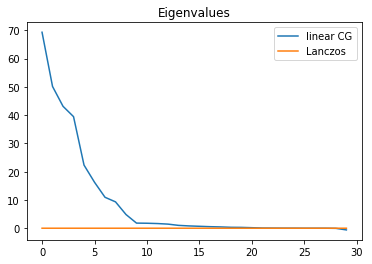

In [20]:
#plt.axhline(0,color='k')
plt.plot(e[e.argsort()[::-1]])
plt.plot(el[el.argsort()[::-1]])
plt.legend(["linear CG", "Lanczos"])
plt.title("Eigenvalues")

In [ ]:
e

In [ ]:
plt.hist(e)
plt.hist(el)

In [ ]:
plt.hist(e[(e>-25000)*(e<100000)], bins=20)

In [ ]:
#plt.hist(eigs4[(eigs4>-25000)*(eigs4<100000)], bins=20)
plt.hist(eigs5[(eigs5>-25000)*(eigs5<100000)], bins=30)
plt.legend(["fd","auto"])
plt.show()

In [ ]:
eigs5

In [ ]:
i = torch.eye(10)

In [ ]:
i[2,2]=3

In [ ]:
e,v = torch.symeig(i, eigenvectors=True)

In [ ]:
e

In [ ]:
v

In [ ]:
i.cuda().symeig()